In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

import sys
sys.path.insert(1, '../library')
sys.path.insert(2, '../python_library')

import pyram as pr

from sklearn.linear_model import LinearRegression
import scipy
from itertools import combinations

from scipy.spatial import distance
from scipy.optimize import minimize

%matplotlib inline

Welcome to pyram: your Raman analysis library!


In [2]:
pr.charge_lib('short')

lib = pr.lib()
lib_names = list(lib.keys())
pr.cwd('example_data')
pr.set_alias()

Charging pure spectra library, needs around a minute ....
Done. Good work!
txt0  ->  Sample01_D_6x4s_633nm_G1200_F100__Ox10.txt
txt1  ->  Sample01_F_10x5s_633nm_G1200_F0_1__Ox100LWD.txt
txt2  ->  Sample01_K_10x10s_633nm_G1200_F10__Ox100LWD.txt
txt3  ->  Sample01_A_10x6s_633nm_G1200_F100__Ox100LWD.txt
txt4  ->  Sample01_G_6x10s_633nm_G1200_F10__Ox100LWD.txt
txt5  ->  Sample01_B_10x30s_633nm_G1200_F1__Ox100LWD.txt
txt6  ->  Sample01_H_10x10s_633nm_G1200_F10__Ox100LWD.txt
txt7  ->  Si_calibration_A_60x1s_633nmnm_G1200_F100__Ox100.txt
txt8  ->  Sample01_C_10x20s_633nm_G1200_F10__Ox100LWD.txt
txt9  ->  Sample01_J_10x5s_633nm_G1200_F10__Ox100LWD.txt
txt10  ->  Sample01_I_10x10s_633nm_G1200_F25__Ox100LWD.txt
txt11  ->  Sample01_E_6x4s_633nm_G1200_F100__Ox100LWD.txt


# Simultaneous bkg and spectra fit

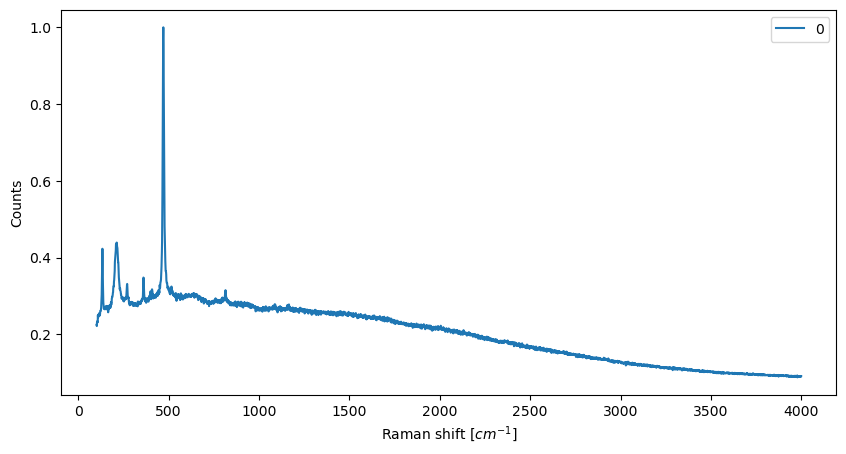

In [3]:
# take an unknown spectra with bkg

S=pr.type2spectra('txt4')
pr.plot(S)

In [4]:
# generate array of gaussian functions

##########
sigma = 100
p = 100
delta = 500 #(>> sigma)
##########

# gaussian function in numpy
def gauss(x, mu, sigma):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))

# sinc function in numpy
def sinc(x, mu, sigma):
    return np.sinc((x-mu)/sigma)

mus = np.linspace(S[0,0]-delta, S[0,-1]+delta, p)

G = np.zeros((p,len(S[0])))
for i in range(p):
    G[i] = sinc(S[0], mus[i], sigma)

## Match with quart

  alias    name
0  lib0  Quartz


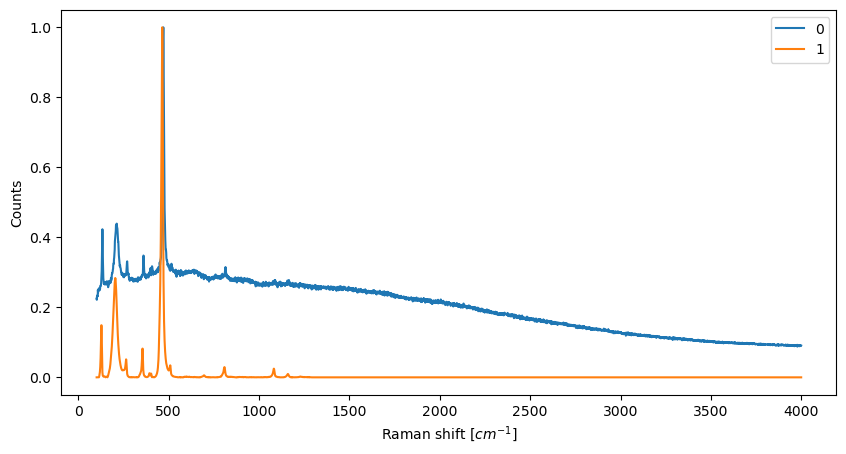

In [5]:
# take a referance

####################################
pr.lib_names('Q')
P = pr.type2spectra('lib0')
####################################

# generate PAD with zeros of P

n_max = np.where(S[0]==P[0][-1])
n_min = np.where(S[0]==P[0][0])

P_pad = np.copy(S)
P_pad[1][n_min[0][0]:n_max[0][0]+1] = P[1]
P_pad[1][0:n_min[0][0]] *= 0 
P_pad[1][n_max[0][0]:] *= 0

pr.plot([S,P_pad])

1603506.5223734863
0.9506993402302043


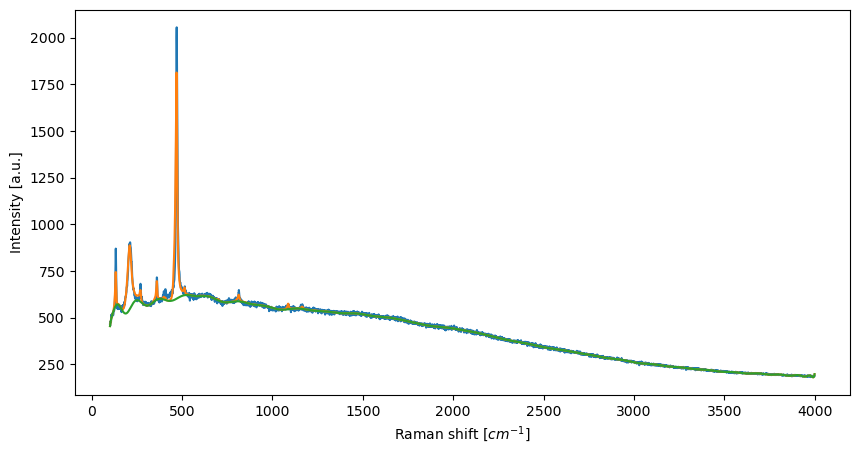

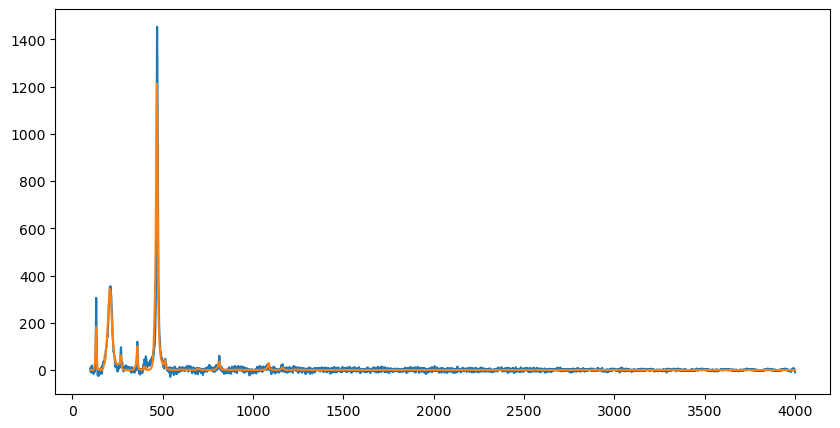

In [6]:
# FIT with shifts

##########
shift = 5
##########
shift_vec = np.arange(-shift,shift+1)




best_res = 0
best_shift = 0

for s in shift_vec:
    P_shifted = np.copy(P_pad)
    P_shifted[1] = np.roll(P_pad[1],s)

    if s>0:
        P_shifted[1][:s] *= 0
    if s<0:
        P_shifted[1][s:] *= 0


    # fit
    Y = np.append([P_shifted[1]], G, axis=0)    # si puo eliminare il transpose ....

    out = scipy.linalg.lstsq(Y.transpose(), S[1])
    
    fit = (Y.transpose()*out[0]).sum(axis=1)
    I = out[0][0]
    bkg = (Y[1:].transpose()*out[0][1:]).sum(axis=1)
    
    res = ((fit-S[1])**2).sum()

    if res<best_res or best_res==0:
        best_res = res
        best_shift = s
        best_fit = fit
        best_bkg = bkg
        best_P_shifted = P_shifted
        best_I = I

res = best_res
shift = best_shift
fit = best_fit
bkg = best_bkg
P_shifted = best_P_shifted
I = best_I


print(res)

plt.figure(figsize=(10,5))
plt.xlabel(r'Raman shift [$cm^{-1}$]')
plt.ylabel('Intensity [a.u.]')
plt.plot(S[0], S[1])
plt.plot(S[0], fit)
plt.plot(S[0], bkg)

plt.figure(figsize=(10,5))
plt.plot(S[0], S[1]-bkg)
plt.plot(P_shifted[0], P_shifted[1]*I)

# cosine similarity between two vectors
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

match = cosine_similarity(S[1]-bkg, P_shifted[1])
print(match)

#plt.xlim(150,1000)

## 1D search in the library

## Select the spectra

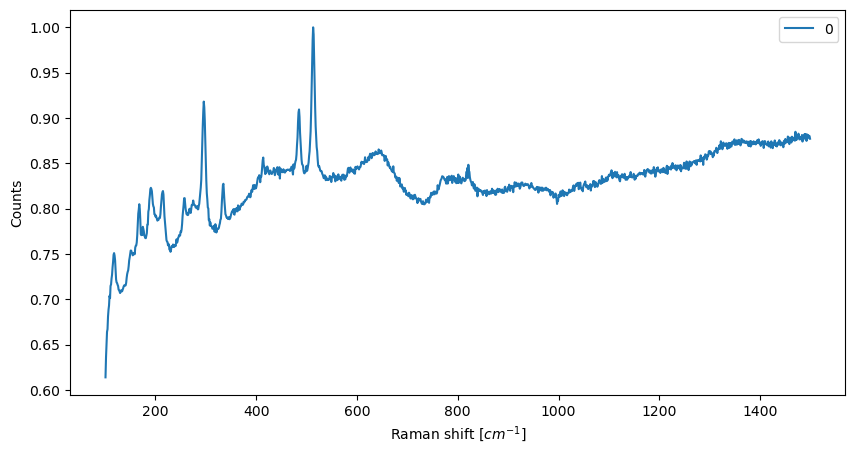

In [17]:
# take an unknown spectra with bkg

S=pr.type2spectra('txt10')
S = S[:,S[0]<1500]
pr.plot(S)

## Prepare resized library

In [89]:
# create matrix LIB

LIB = np.zeros((len(lib_names), len(S[0])))

for i in range(len(lib_names)):
    P = np.copy(lib[lib_names[i]])

    # restringo P se troppo grande
    if P[0][0]<S[0][0] or P[0][-1]>S[0][-1]:
        P = P[:,P[0]>=S[0][0]]
        P = P[:,P[0]<=S[0][-1]]



    # generate PAD with zeros of P
    n_min = np.where(S[0]==P[0][0])
    n_max = np.where(S[0]==P[0][-1])
    
    P_pad = np.copy(S)
    P_pad[1][n_min[0][0]:n_max[0][0]+1] = P[1]
    P_pad[1][0:n_min[0][0]] *= 0 
    P_pad[1][n_max[0][0]:] *= 0

    LIB[i] = P_pad[1]/(np.linalg.norm(P))

## Matrice di bkg template functions

In [143]:
# generate array of bkg template functions

##########
sigma = 40
p = 100
delta = 0 #(>> sigma)
method = 'sinc'
##########

# gaussian function in numpy
def gauss(x, mu, sigma):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))

# sinc function in numpy
def sinc(x, mu, sigma):
    return np.sinc((x-mu)/sigma)

mus = np.linspace(S[0,0]-delta, S[0,-1]+delta, p)

G = np.zeros((p,len(S[0])))

if method == 'gauss':
    for i in range(p):
        G[i] = gauss(S[0], mus[i], sigma)

if method == 'sinc':
    for i in range(p):
        G[i] = sinc(S[0], mus[i], sigma)

### Genero LIB_shifted

In [144]:
#######################
####### PREFIT ########
#######################

##########
shift = 5
##########
shift_vec = np.arange(-shift,shift+1)

# cosine similarity between two vectors
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


output = []

LIB_shifted = np.zeros((len(lib_names)*(2*shift+1), len(S[0])))

for i in range(len(lib_names)):

    for s in range(len(shift_vec)):

        LIB_shifted[i*(2*shift+1)+s] = np.roll(LIB[i],shift_vec[s])

        if s>0:
            LIB_shifted[i*(2*shift+1)+s][:shift_vec[s]] *= 0
        if s<0:
            LIB_shifted[i*(2*shift+1)+s][shift_vec[s]:] *= 0

In [92]:
#### FIT
Y = np.append(LIB_shifted, G, axis=0)    # si puo eliminare il transpose ....
#out = scipy.linalg.lstsq(Y.transpose(), S[1])
out = scipy.optimize.nnls(Y.transpose(), S[1])

#lb = np.append(np.zeros(LIB_shifted.shape[0]), -np.ones(G.shape[0])*np.inf)
#ub = np.ones(LIB_shifted.shape[0] + G.shape[0])*np.inf
#out = scipy.optimize.lsq_linear(Y.transpose(), S[1], bounds=(lb,ub))

# salvo risultato
fit = (Y.transpose()*out[0]).sum(axis=1)

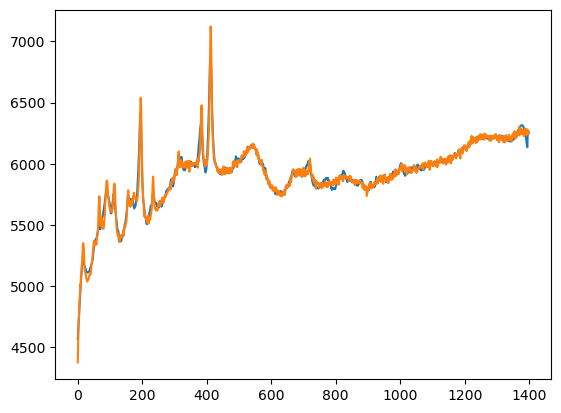

In [145]:
plt.plot(fit)
plt.plot(S[1])

,name,ID,match,res,I,bkg,fit
0,Albite__R050253__Raman__514,22,0.985258,6.966308e+05,"[0.020135996492397494, 5.438543447138597, 6.22...","[4454.906125068665, 4513.603046417236, 4583.72...","[4464.339718818665, 4516.524921417236, 4579.67..."
1,Albite__R050402__Raman__780,4416,0.984326,7.698918e+05,"[-0.00948209587857171, -7602133256657.354, 254...","[4451.252670764923, 4518.184784412384, 4593.63...","[4451.252670764923, 4518.184784412384, 4593.63..."
2,Albite__R040129__Raman__514,1398,0.980461,8.464228e+05,"[0.003425204825900802, 3036014993059.7993, -29...","[4506.423011779785, 4528.659585952759, 4576.31...","[4506.423011779785, 4528.659585952759, 4576.31..."
3,Albite__R050402__Raman__514,1577,0.980262,9.384085e+05,"[0.010830969298122332, 164.8132949757223, -962...","[4441.320275306702, 4517.590503692627, 4595.74...","[4440.587853431702, 4512.345386505127, 4590.78..."
4,Albite__R040068__Raman__514,2349,0.969851,1.241650e+06,"[0.05070509298094861, 1565825078508.9514, -302...","[4443.303328990936, 4506.396834850311, 4579.76...","[4443.303328990936, 4506.396834850311, 4579.76..."
5,Albite__R050402__Raman__532,2680,0.978460,1.248562e+06,"[0.005162650188064571, 10572176469952.025, 286...","[4443.919540405273, 4515.767983913422, 4594.68...","[4443.919540405273, 4515.767983913422, 4594.68..."
6,Rubicline__R070044__Raman__785,4484,0.969289,1.256327e+06,"[-0.0004080265043933012, 12601790035242.531, -...","[4462.078568220139, 4508.451208114624, 4571.71...","[4462.078568220139, 4508.451208114624, 4571.71..."
7,Albite__R040129__Raman__532,5010,0.970554,1.302102e+06,"[0.0021793556413532704, 2302276947038.318, 373...","[4477.276866912842, 4517.98225402832, 4578.258...","[4477.276866912842, 4517.98225402832, 4578.258..."
8,Albite__R050253__Raman__780,4461,0.972996,1.306419e+06,"[0.003777349253940792, -25111572627469.273, -3...","[4666.344379425049, 4580.307102203369, 4559.12...","[4666.344379425049, 4580.307102203369, 4559.12..."
9,Rubicline__R070044__Raman__532,2393,0.954066,1.822170e+06,"[0.004217566424666695, -835384705267.1777, -40...","[4452.592199087143, 4513.500048160553, 4585.29...","[4452.592199087143, 4513.500048160553, 4585.29..."


[ 2.01359965e-02  5.43854345e+00  6.22562827e+00  1.08653848e+01
  2.35162094e+01  9.38927612e-01  6.42944081e-02  3.16970238e-02
  1.03774486e-01 -3.08031471e-01  1.89860424e-01]


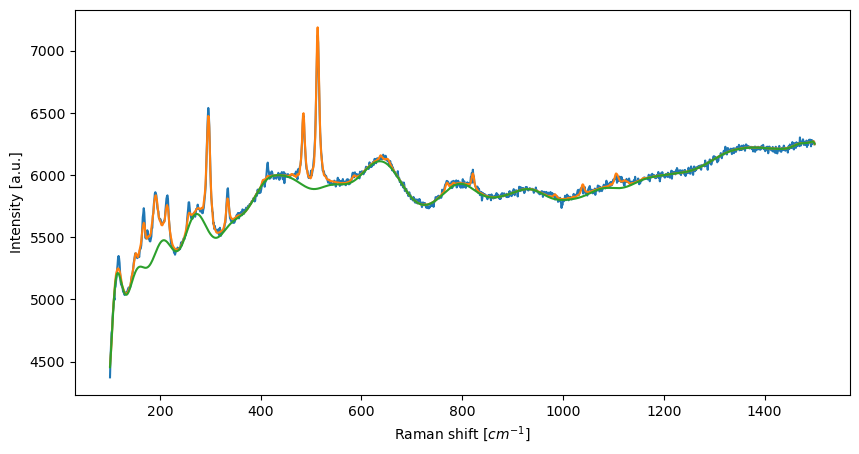

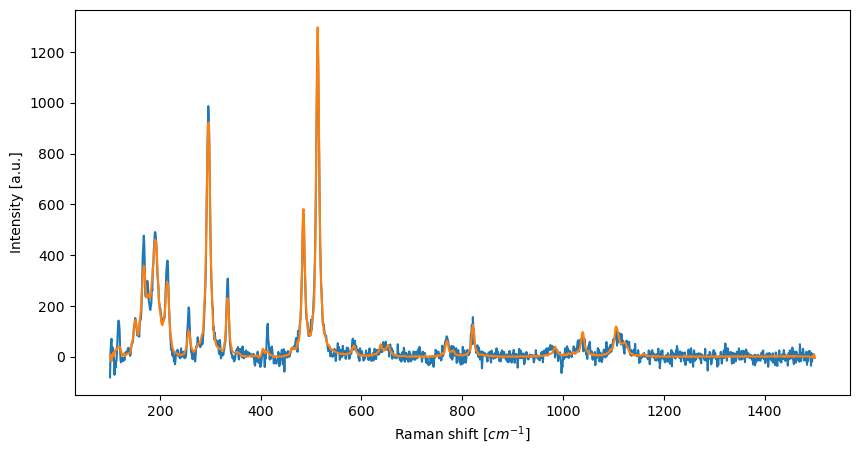

In [369]:
# FIT with shifts
# cosine similarity between two vectors
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


##########
shift = 5
##########
shift_vec = np.arange(-shift,shift+1)


output = []

Ps = np.zeros((2*shift+1, len(S[0])))

for i in range(len(lib_names)):

    for s in range(len(shift_vec)):

        P_shifted = np.roll(LIB[i],shift_vec[s])

        if s>0:
            P_shifted[:shift_vec[s]] *= 0
        if s<0:
            P_shifted[shift_vec[s]:] *= 0

        Ps[s] = P_shifted

    #### fit
    Y = np.append(Ps, G, axis=0)    # si puo eliminare il transpose ....
    out = scipy.linalg.lstsq(Y.transpose(), S[1])
    
    # salvo risultato
    fit = (Y.transpose()*out[0]).sum(axis=1)
    I = out[0][:2*shift+1]
    bkg = (Y[2*shift+1:].transpose()*out[0][2*shift+1:]).sum(axis=1)
    
    # riassumo info
    res = ((fit-S[1])**2).sum()
    LIB[i]= np.sum(I * Ps.transpose(), axis=1)
    match = cosine_similarity(S[1]-bkg, LIB[i])

    # SALVO
    output.append([lib_names[i], i, match, res, I, bkg, fit])
    
output = pd.DataFrame(output, columns=['name', 'ID', 'match', 'res', 'I', 'bkg', 'fit']).sort_values(by='res', ascending=True).reset_index(drop=True)
display(output.head(10))

print(output['I'][0])

plt.figure(figsize=(10,5))
plt.xlabel(r'Raman shift [$cm^{-1}$]')
plt.ylabel('Intensity [a.u.]')

plt.plot(S[0], S[1])
plt.plot(S[0], output['fit'][0])
plt.plot(S[0], output['bkg'][0])

plt.figure(figsize=(10,5))
plt.xlabel(r'Raman shift [$cm^{-1}$]')
plt.ylabel('Intensity [a.u.]')
plt.plot(S[0], S[1]-output['bkg'][0])
plt.plot(S[0], LIB[output['ID'][0]])

In [361]:
'''
# FIT with shifts
# cosine similarity between two vectors
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

##########
shift = 5
##########
shift_vec = np.arange(-shift,shift+1)


output = []

for i in range(len(lib_names)):

    best_res = 0
    best_shift = 0

    for s in shift_vec:

        P_shifted = np.roll(LIB[i],s)

        if s>0:
            P_shifted[:s] *= 0
        if s<0:
            P_shifted[s:] *= 0

        # fit
        Y = np.append([P_shifted], G, axis=0)    # si puo eliminare il transpose ....

        out = scipy.linalg.lstsq(Y.transpose(), S[1])
        
        fit = (Y.transpose()*out[0]).sum(axis=1)
        I = out[0][0]
        bkg = (Y[1:].transpose()*out[0][1:]).sum(axis=1)
        
        res = ((fit-S[1])**2).sum()

        if res<best_res or best_res==0:
            best_res = res
            best_shift = s
            best_fit = fit
            best_bkg = bkg
            best_P_shifted = P_shifted
            best_I = I

    res = best_res
    shift = best_shift
    fit = best_fit
    bkg = best_bkg
    LIB[i]= best_P_shifted
    I = best_I

    match = cosine_similarity(S[1]-bkg, LIB[i])

    output.append([lib_names[i], i, match, res, shift, I, bkg, fit])
    
output = pd.DataFrame(output, columns=['name', 'ID', 'match', 'res', 'shift', 'I', 'bkg', 'fit']).sort_values(by='res', ascending=True).reset_index(drop=True)
display(output.head(10))

plt.figure(figsize=(10,5))
plt.xlabel(r'Raman shift [$cm^{-1}$]')
plt.ylabel('Intensity [a.u.]')

plt.plot(S[0], S[1])
plt.plot(S[0], output['fit'][0])
plt.plot(S[0], output['bkg'][0])

plt.figure(figsize=(10,5))
plt.xlabel(r'Raman shift [$cm^{-1}$]')
plt.ylabel('Intensity [a.u.]')
plt.plot(S[0], S[1]-output['bkg'][0])
plt.plot(S[0], LIB[output['ID'][0]]*output['I'][0])
'''

"\n# FIT with shifts\n# cosine similarity between two vectors\ndef cosine_similarity(v1, v2):\n    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))\n\n##########\nshift = 5\n##########\nshift_vec = np.arange(-shift,shift+1)\n\n\noutput = []\n\nfor i in range(len(lib_names)):\n\n    best_res = 0\n    best_shift = 0\n\n    for s in shift_vec:\n\n        P_shifted = np.roll(LIB[i],s)\n\n        if s>0:\n            P_shifted[:s] *= 0\n        if s<0:\n            P_shifted[s:] *= 0\n\n        # fit\n        Y = np.append([P_shifted], G, axis=0)    # si puo eliminare il transpose ....\n\n        out = scipy.linalg.lstsq(Y.transpose(), S[1])\n        \n        fit = (Y.transpose()*out[0]).sum(axis=1)\n        I = out[0][0]\n        bkg = (Y[1:].transpose()*out[0][1:]).sum(axis=1)\n        \n        res = ((fit-S[1])**2).sum()\n\n        if res<best_res or best_res==0:\n            best_res = res\n            best_shift = s\n            best_fit = fit\n            best_bkg =

In [287]:
pr.search(S)

  alias         name     match
0  sch0    Lizardite  0.568559
1  sch1   Nontronite  0.523666
2  sch2  Armalcolite  0.512387
3  sch3      Zoisite  0.495684
4  sch4       Augite  0.492536
5  sch5      Epidote  0.487337
6  sch6      Amesite  0.446122
7  sch7     Titanite  0.433988
8  sch8    Muscovite  0.431066
9  sch9     Chromite  0.425424


,alias,name,match
0,sch0,Lizardite,0.568559
1,sch1,Nontronite,0.523666
2,sch2,Armalcolite,0.512387
3,sch3,Zoisite,0.495684
4,sch4,Augite,0.492536
...,...,...,...
56,sch56,Gypsum,0.193613
57,sch57,Pyrite,0.192791
58,sch58,Anatase,0.176383
59,sch59,Lithiophilite,0.171602


# ND search

In [23]:
########### WORKING WITH ##############
shift = 5
S # the spectrum
set_min = 100
set_max = 1500
improvement_th = 0.1 # threshold on the improvement of the similarity
th = 0.01 # trashold on the linear regression coefficients
bin=5    # binning for the linear regression speedup
############################################

#pr.charge_lib('full')

In [24]:
lib=pr.lib()
lib_names=list(lib.keys())

###################################################################################
########### PUTTING THE LIBRARY IN AN NP.ARRAY with the computed shifts ###########
###################################################################################

# the nan values are padded with zeros!
m = len(lib_names)

# searching the minimum and the maximum wn of the library (to get the # of columns)
min = lib[lib_names[0]][0].min()
max = lib[lib_names[0]][0].max()

for el in lib_names[1:]:
    min_t = lib[el][0].min()
    max_t = lib[el][0].max()

    if min_t<min:
        min = min_t
    if max_t>max:
        max = max_t

wn = np.arange(min-shift,max+1+shift,1)
n = len(wn+2*shift)

# rewriting the library in a np.array
LIB = np.zeros((m,n))

for i in range(len(lib_names)):
    min_t = lib[lib_names[i]][0].min()
    max_t = lib[lib_names[i]][0].max()
    
    # computing the shift
    match = 0
    for s in np.arange(-shift,shift+1):
        B_temp = lib[lib_names[i]].copy()
        B_temp[0] += s

        match_new = pr.cos_sim(S,B_temp)                                       #################
        if match_new>match:
            match = match_new
            out = s

    #adding the shifted spectra to the library
    LIB[i][int(min_t-min+shift)+out:n-int(max-max_t+shift)+out]  = lib[lib_names[i]][1]

# rescaling the height to 1
LIB = (LIB.transpose()/LIB.max(axis=1)).transpose()

In [25]:
###############################################################################################
############# CHANGING LIBRARY OF THE SPECTRA, SPECIFYING FOR THE S WE ARE FACING #############
###############################################################################################

# here we prepare common wn between S and the library

# ausiliar variables
S_work = copy.deepcopy(S)
S_work[1] = S_work[1]/S_work[1].max()

# changing dimensions of LIB_temp or S_work
min_1 = np.min(S_work[0])
min_2 = np.min(wn)
max_1 = np.max(S_work[0])
max_2 = np.max(wn)

# se set_min o set_max sono settati male sistemali
set_min = np.max([min_1,set_min])
set_max = np.min([max_1,set_max])

if set_min==None: #i.e se non è settato un minimo settalo come quello comune
    min = np.max([min_1,min_2])
else:
    min = set_min
if set_max==None: #i.e se non è settato un massimo settalo come quello comune
    max = np.min([max_1,max_2])
else:
    max = set_max

if min_1<min:
    S_work = S_work[:,int(min-min_1):]
if min_2<min:
    wn = wn[int(min-min_2):]
    LIB = LIB[:,int(min-min_2):]
if max_1>max:
    S_work = S_work[:,:int(max-max_1)]
if max_2>max:
    wn = wn[:int(max-max_2)]
    LIB = LIB[:,:int(max-max_2)]

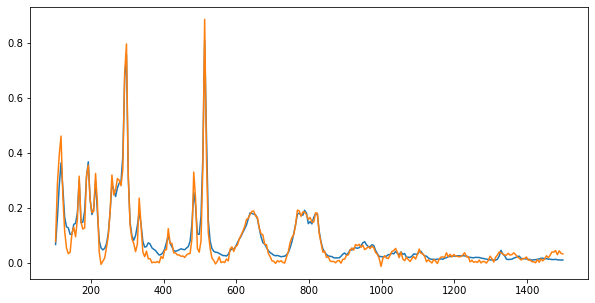

################################################################
# of used spectra =  42
      ID                                    name  regression coefficient
0     83             Albite__R050402__Raman__514                0.295111
1    500         Barysilite__R050002__Raman__514                0.093879
2    659           Bixbyite__R050395__Raman__785                0.212448
3    772         Bromellite__R050194__Raman__514                0.015718
4    782      Brunogeierite__R090012__Raman__532                0.026219
5    856         Caledonite__R060506__Raman__532                0.030701
6    861            Calomel__R070370__Raman__532                0.084919
7    862            Calomel__R070370__Raman__785                0.154984
8    901        Cassiterite__R040017__Raman__514                0.011902
9    944          Cerussite__R050023__Raman__514                0.025870
10  1007       Chalcopyrite__R050208__Raman__532                0.445385
11  1092           Cinnabar__R05007

In [26]:
#############################################################################################
############# LINEAR REGRESSION FOR THE SEARCH OF USEFUL SPECTRA IN THE LIBRARY #############
#############################################################################################
 
# binning for the speed up of the linear regression
LIB_temp = LIB[:,:(LIB.shape[1] // bin)*bin].reshape(LIB.shape[0],LIB.shape[1]//bin,bin).mean(axis=2)
wn_temp = wn[:(wn.shape[0] // bin)*bin].reshape(wn.shape[0]//bin,bin).mean(axis=1)
S_temp = S_work[:,:(S_work.shape[1] // bin)*bin].reshape(S_work.shape[0],S_work.shape[1]//bin,bin).mean(axis=2)

# linear regression
reg = LinearRegression(fit_intercept=False, positive=True)
reg.fit(LIB_temp.transpose(),S_temp[1])

# plot the regression
plt.figure(figsize=(10,5))
plt.plot(wn_temp,np.dot(LIB_temp.transpose(),reg.coef_))
plt.plot(S_temp[0],S_temp[1])
plt.show()

# number of used spectrums, selection of rely used spectra
lib_used = []
for i in range(len(reg.coef_)):
    if reg.coef_[i]>th:
        lib_used.append(i)

print('################################################################')
print('# of used spectra = ',len(lib_used))

# selected spectra sumup
sumup = []
for i in range(len(lib_used)):
    sumup.append([lib_used[i],lib_names[lib_used[i]] , reg.coef_[lib_used[i]]])

sumup = pd.DataFrame(sumup, columns=['ID','name','regression coefficient'])
print(sumup)

In [27]:
#########################################################################################
############# GENERATION OF THE REQUIRED SPECTRA IN THE RIGHT CONFIGURATION #############
#########################################################################################

# generation of the required pure spectra (also shifted)
pure = np.take(LIB,list(sumup.ID),axis=0)

(42, 1400)

In [28]:
# definition of the ND cosine similarity
def ND_cos_sim(S,X):

    if X.shape[0]>1:
        # riempio la matrice X
        X = X.transpose()

        # calcolo la trasposta
        Xt = X.transpose()

        # calcolo la proiezione
        w = np.linalg.multi_dot([X ,np.linalg.inv( np.dot(Xt,X) ), Xt, S[1]])

        # e infine la cosine similarity
        match = 1-distance.cosine(w,S[1])

    if X.shape[0]==1:
        match = 1-distance.cosine(LIB[el],S[1])

    return match

In [29]:
#############################################################
############# FINAL FIT USING COSINE SIMILARITY #############
#############################################################
# (here at fixed N)

N = 2


# genero le N combinazioni tra i pure spectra selezionati
comb = list(combinations(list(sumup.index),N))

print('trying N =', N,'; resulting in', len(comb), 'combinations')

# and finaly let's compute the similarity for each combination
results = [0]*len(comb)

for c in enumerate(comb):
    
    if N>1:
        # minimization of the problem
        X = pure.take(c[1],axis=0)

        # store results
        # combination, similarity
        results[c[0]] = [c[1], ND_cos_sim(S_work,X) ]
    
    if N==1:
        tot = pure[c[1][0]]
        results[c[0]] = [c[1], np.dot(S_work[1],tot) / np.sqrt(np.dot(S_work[1],S_work[1])*np.dot(tot,tot)) ]

# decode results

for i in range(len(results)):
    temp = [0]*N
    for j in range(N):
        temp[j]= sumup.name[results[i][0][j]]

    results[i][0] = temp

results = pd.DataFrame(results, columns=['combination','similarity'])


results.sort_values(by=['similarity'], inplace=True, ascending=False)
results.reset_index(inplace=True,drop=True)

display(results.head())

trying N = 2 ; resulting in 861 combinations


,combination,similarity
0,"[Albite__R050402__Raman__514, Jamesonite__R050...",0.896075
1,"[Albite__R050402__Raman__514, Magnetite__R0800...",0.889092
2,"[Albite__R050402__Raman__514, Paralaurionite__...",0.887344
3,"[Albite__R050402__Raman__514, Diamond__R050204...",0.885887
4,"[Albite__R050402__Raman__514, Natroboltwoodite...",0.883586


In [32]:
######################################
############# CYCLE ON N #############
######################################

N = 0
improvement = 1
out = []

while improvement>improvement_th:
    N += 1

    # genero le N combinazioni tra i pure spectra selezionati
    comb = list(combinations(list(sumup.index),N))

    print('trying N =', N,'; resulting in', len(comb), 'combinations')

    # and finaly let's compute the similarity for each combination
    match = [0]*len(comb)

    for c in enumerate(comb):
        
        if N>1:
            # minimization of the problem
            X = pure.take(c[1],axis=0)

            # store results
            # combination, similarity
            match[c[0]] = [c[1], ND_cos_sim(S_work,X) ]
        
        if N==1:
            tot = pure[c[1][0]]
            match[c[0]] = [c[1], np.dot(S_work[1],tot) / np.sqrt(np.dot(S_work[1],S_work[1])*np.dot(tot,tot)) ]

    # decode results
    for i in range(len(match)):
        temp = [0]*N
        for j in range(N):
            temp[j]= sumup.name[match[i][0][j]]

        match[i].append(match[i][0])
        match[i][0] = temp

    match = pd.DataFrame(match, columns=['combination','match','ID'])


    match.sort_values(by=['match'], inplace=True, ascending=False)
    match.reset_index(inplace=True,drop=True)


    out.append(match)
    if N>1:
        improvement = (out[N-1].match.max()-out[N-2].match.max())/out[N-2].match.max()
    

print('########################################################')
print('best at N =', N-1)
print(out[N-2].head(10))
print('########################################################')

trying N = 1 ; resulting in 42 combinations
trying N = 2 ; resulting in 861 combinations
########################################################
best at N = 1
                               combination     match     ID
0            [Albite__R050402__Raman__514]  0.850721   (0,)
1         [Rubicline__R070044__Raman__785]  0.809573  (34,)
2           [Coesite__R070565__Raman__780]  0.576250  (12,)
3        [Barysilite__R050002__Raman__514]  0.570056   (1,)
4      [Chalcopyrite__R050208__Raman__532]  0.562018  (10,)
5          [Jamesonite__R050430_b__Raman_]  0.558195  (19,)
6        [Miargyrite__R050440__Raman__532]  0.537710  (23,)
7           [Silicon__R040145__Raman__514]  0.463791  (37,)
8         [Magnetite__R080025__Raman__780]  0.433182  (22,)
9  [Tvalchrelidzeite__R061128__Raman__785]  0.426048  (41,)
########################################################


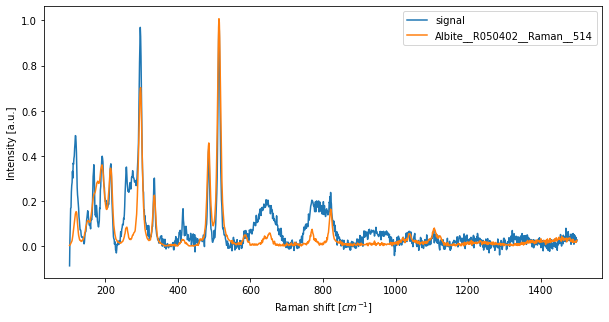

In [31]:
IDs = list(out[N-2].iloc[0].ID)
Names = list(out[N-2].iloc[0].combination)

def f(C):
    tot = np.sum(pure.take(IDs,axis=0).transpose()*C,axis=1)
    #return -np.dot(S_work[1],tot) / np.sqrt(np.dot(S_work[1],S_work[1])*np.dot(tot,tot))
    return np.sum((tot-S_work[1])**2)

C = minimize(f,np.ones(len(IDs)))['x']

plt.figure(figsize=(10,5))
plt.xlabel(r'Raman shift [$cm^{-1}$]')
plt.ylabel('Intensity [a.u.]')

plt.plot(S_work[0],S_work[1],label='signal')
for i in enumerate(IDs):
    plt.plot(wn,pure[i[1]]*C[i[0]], label=Names[i[0]])

plt.legend()

## Some test

sum(Y-XW) =  -18247053.508028295
message =  Optimization terminated successfully.
# of iter =  830


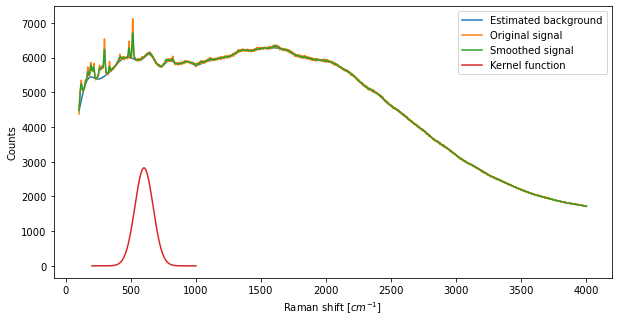

trying N = 1 ; resulting in 10 combinations
search with N = 1


,combination,match
0,[Albite],0.806941
1,[Microcline],0.669265
2,[Chalcopyrite],0.622315
3,[Arsenopyrite],0.397458
4,[Lepidocrocite],0.367780
5,[Muscovite],0.352152
6,[Phlogopite],0.320751
7,[Jarosite],0.308897
8,[Pyrophyllite],0.299624
9,[Siderite],0.282819


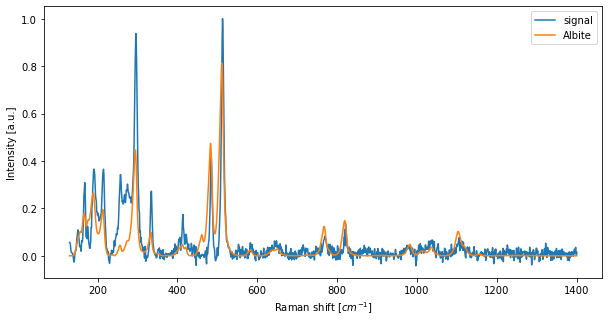

In [ ]:
S=pr.type2spectra('txt8')
S=pr.bkg_subtraction(S,sigma=70, p=300, plot=True, L_n=11)
#pr.plot(S)

pr.NDsearch(S, set_min=130, set_max=1400, shift=5, improvement_th=0.1, fixed_N=1)